# Neurosymbolic Software Tutorial - Discrete - Solution

<a target="_blank" href="https://colab.research.google.com/github/kavigupta/neurosym-lib/blob/main/tutorial/discrete_exercise_solutions.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executible code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side.
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, and opening this notebook from within Google Drive.


## Outline

- Part 1: Defining a DSL
- Part 2: Finding Programs
- Part 3: Abstraction Learning

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import itertools
import neurosym as ns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("error")

## Part 1: Defining a DSL

We would like to be able to define arithmetic functions, of various types.

### Exercise 1A: Create a DSL

We would like our DSL to be able to represent the following functions. **For future experiments, make sure you don't include cosine.**

- $f_0(x) = x + 1$
- $f_1(x) = x^2 + \frac{x}{\sin x}$
- $f_2(x) = (x + 2)^x$
- $f_3(x) = \begin{cases}
x^2 & x < 0\\
\sqrt {x^2 + 1} & x \geq 0\\
\end{cases}$

In [2]:
dslf = ns.DSLFactory()
dslf.concrete("0", "() -> f", lambda: 0)
dslf.concrete("1", "() -> f", lambda: 1)
dslf.concrete("2", "() -> f", lambda: 2)
dslf.concrete("+", "(f, f) -> f", lambda x, y: x + y)
dslf.concrete("-", "(f, f) -> f", lambda x, y: x - y)
# BEGIN SOLUTION "YOUR CODE HERE"
dslf.concrete("*", "(f, f) -> f", lambda x, y: x * y)
dslf.concrete("**", "(f, f) -> f", lambda x, y: x ** y)
dslf.concrete("/", "(f, f) -> f", lambda x, y: x / y)
dslf.concrete("sin", "f -> f", np.sin)
dslf.concrete("sqrt", "f -> f", np.sqrt)
dslf.concrete("<", "(f, f) -> b", lambda x, y: x < y)
dslf.concrete("ite", "(b, f, f) -> f", lambda cond, x, y: x if cond else y)
# END SOLUTION
dslf.lambdas()
dslf.prune_to("f -> f")
dsl = dslf.finalize()

### DSL Printout

See your DSL printed below, and ensure it is what you would expect

In [3]:
print(dsl.render())

              0 :: () -> f
              1 :: () -> f
              2 :: () -> f
              + :: (f, f) -> f
              - :: (f, f) -> f
              * :: (f, f) -> f
             ** :: (f, f) -> f
              / :: (f, f) -> f
            sin :: f -> f
           sqrt :: f -> f
              < :: (f, f) -> b
            ite :: (b, f, f) -> f
            lam :: L<#body|f> -> f -> #body
           $0_0 :: V<f@0>


### Exercise 1B: Write your functions

We have provided $f_0$, it is up to you to write $f_1$ through $f_3$. Note that there are no leaf nodes in the neurosym DSLs, so terminal productions are represented as s-expressions with no children. Run the tests in the following cell to make sure your DSL and programs are working properly

In [4]:
f_0 = "(lam (+ ($0_0) (1)))"
# BEGIN SOLUTION "YOUR CODE HERE"
f_1 = "(lam (+ (** ($0_0) (2)) (/ ($0_0) (sin ($0_0)))))"
f_2 = "(lam (** (+ ($0_0) (2)) ($0_0)))"
f_3 = "(lam (ite (< ($0_0) (0)) (** ($0_0) (2)) (sqrt (+ (1) (** ($0_0) (2))))))"
# END SOLUTION

In [5]:
def test_program(actual_program, expected_fn):
    actual_fn = dsl.compute(dsl.initialize(ns.parse_s_expression(actual_program)))
    inputs = np.linspace(-1, 1, 100)
    actual = np.array([actual_fn(x) for x in inputs])
    expected = np.array([expected_fn(x) for x in inputs])
    delta = np.abs(actual - expected)
    bad = delta > 1e-5
    if (~bad).all():
        return
    [[bad_input, *_]] = np.where(bad)
    raise AssertionError(f"On input {inputs[bad_input]}, expected {expected[bad_input]} but recvd {actual[bad_input]}")

test_program(f_0, lambda x: x + 1)
test_program(f_1, lambda x: x ** 2 + x / np.sin(x))
test_program(f_2, lambda x: (x + 2) ** x)
test_program(f_3, lambda x: x ** 2 if x < 0 else (x ** 2 + 1) ** 0.5)

## Part 2: Finding Programs

To begin with, we look into using enumeration to find programs. Since we don't have a set of programs to fit a distribution to, we start with a ``uniform PCFG'' (minor note: this is an ill-defined PCFG in this case since sampling from it has a high probability of divergence. it doesn't matter to the enumeration algorithm, however).

In [6]:
dist_family = ns.BigramProgramDistributionFamily(dsl)
uniform = dist_family.uniform()

We can enumerate programs from this distribution by running the `dist_family.enumerate` command. This produces an infinite stream of programs, which we can limit with `islice` as below:

In [7]:
for prog, like in itertools.islice(dist_family.enumerate(uniform), 10):
    print(ns.render_s_expression(prog), like)

(lam ($0_0)) -2.4849066734313965
(lam (0)) -2.4849066734313965
(lam (1)) -2.4849066734313965
(lam (2)) -2.4849066734313965
(lam (sin ($0_0))) -4.969813346862793
(lam (sin (0))) -4.969813346862793
(lam (sin (1))) -4.969813346862793
(lam (sin (2))) -4.969813346862793
(lam (sqrt ($0_0))) -4.969813346862793
(lam (sqrt (0))) -4.969813346862793


We can also specify a minimum likelihood, and guarantee that we see all programs above that likelihood:

In [8]:
for prog, like in dist_family.enumerate(uniform, min_likelihood=-5):
    print(ns.render_s_expression(prog), like)

(lam ($0_0)) -2.4849066734313965
(lam (0)) -2.4849066734313965
(lam (1)) -2.4849066734313965
(lam (2)) -2.4849066734313965
(lam (sin ($0_0))) -4.969813346862793
(lam (sin (0))) -4.969813346862793
(lam (sin (1))) -4.969813346862793
(lam (sin (2))) -4.969813346862793
(lam (sqrt ($0_0))) -4.969813346862793
(lam (sqrt (0))) -4.969813346862793
(lam (sqrt (1))) -4.969813346862793
(lam (sqrt (2))) -4.969813346862793


### Exercise 2: Finding a program

Finish the following function below, which, given a distribution, a list of inputs and a list of outputs, finds a program matching those inputs and outputs, within epsilon at all locations. It might be helpful to look at the `test_program` method above to see how to run programs. Important detail: you will want to handle errors and `nan` values gracefully. For this, we provide the `run_safely` function, that takes a function and input and runs it, returning `None` if its output is `nan` or an error.

In [25]:
def run_safely(f, x):
    try:
        y = f(x)
    except:
        return None
    if np.isnan(y):
        return None
    return y

def find_program(dist, inputs, outputs, epsilon):
    # BEGIN SOLUTION "YOUR CODE HERE"
    for prog, _ in dist_family.enumerate(dist):
        actual_fn = dsl.compute(dsl.initialize(prog))
        for i, o in zip(inputs, outputs):
            y = run_safely(actual_fn, i)
            if y is None or abs(y - o) > epsilon:
                break
        else:
            return prog
    # END SOLUTION

Run the following tests to ensure your implementation is correct:

In [10]:
def find_program_for_function(dist, fn, epsilon):
    inputs = np.linspace(-2, 2)
    outputs = fn(inputs)
    return find_program(dist, inputs, outputs, epsilon)

assert ns.render_s_expression(find_program_for_function(uniform, lambda x: x * 2, 0)) == '(lam (* ($0_0) (2)))'
assert ns.render_s_expression(find_program_for_function(uniform, np.abs, 0.001)) == '(lam (sqrt (* ($0_0) ($0_0))))'
assert ns.render_s_expression(find_program_for_function(uniform, lambda x: x + 0.05, 0.1)) == '(lam ($0_0))'

You will notice in the second test above, the enumerator came up with a "creative" solution to the absolute value problem. This is because this ended up being an easier to find solution than the more obvious `(lam (ite (< ($0_0) (0)) (- (0) ($0_0)) ($0_0)))`.

The following cell will take slightly longer to run, but you can see that it is able to identify a solution for $\cos^2 \theta$

In [11]:
ns.render_s_expression(find_program_for_function(uniform, lambda x: np.cos(x) ** 2, 0.001))

'(lam (- (1) (** (sin ($0_0)) (2))))'

## Part 3: Abstraction Learning

We start by introducing a dataset of smoothed sequences. These sequences have values roughly in the range $[-2, 2]$ are generally smoothed. We generate this data below:

In [23]:
xs, values = ns.examples.simple_dreamcoder.example_dataset(1000, 20)

def plot_some_sequences():
    for i in range(3):
        plt.plot(xs, values[i], color=f"C{i}", alpha=0.25)
        plt.scatter(xs, values[i], color=f"C{i}", marker=".")

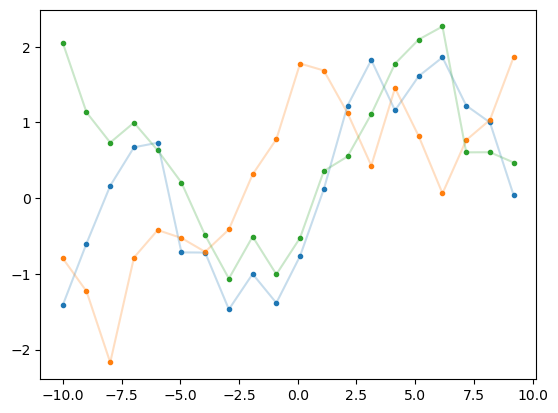

In [24]:
plot_some_sequences()

We provide a function for finding the best program out of a list that matches a given data sequence:

In [ ]:
def evaluate_all_programs(dsl, programs):
    filtered_programs, evaluations = [], []
    for prog in programs:
        try:
            actual_fn = dsl.compute(dsl.initialize(prog))
        except:
            continue
        ys = []
        for inp in xs:
            y = run_safely(actual_fn, inp)
            if y is None or not (-2 <= y <= 2):
                break
            ys.append(y)
        else:
            filtered_programs.append(prog)
            evaluations.append(ys)
    return filtered_programs, np.array(evaluations)

def best_fits(dsl, family, dist):
    programs = [prog for prog, _ in itertools.islice(family.enumerate(dist), 5000)]
    programs = sorted(programs, key=lambda x: len(ns.render_s_expression(x)))
    filtered_programs, ys = evaluate_all_programs(dsl, programs)
    errors = ((ys[None] - values[:,None]) ** 2).sum(-1)
    program_idxs = errors.argmin(1)
    print("Mean error: ", errors.min(1).mean())
    return [filtered_programs[i] for i in program_idxs]

def plot_programs_against_data(dsl, best_programs):
    plot_some_sequences()
    best_programs = best_programs[:plot_count]
    _, evals = evaluate_all_programs(dsl, best_programs)
    for prog, ev in zip(best_programs, evals):
        plt.plot(xs, ev, label=ns.render_s_expression(prog).replace("$", r"\$"))
    plt.legend()

Now we find the best programs among the first 50k enumerated programs

In [ ]:
best_programs = best_fits(dsl, dist_family, uniform)

In [ ]:
plot_programs_against_data(dsl, best_programs)

### Exercise 3A: Fitting a DSL

Fit a function to the `best_programs`. Useful functions to know are `dist_family.fit_distribution` and `distribution.bound_minimum_likelihood`. Use a parameter of 0.01 as the minimum likelihood.

In [ ]:
# BEGIN SOLUTION fitted_dist = ______
fitted_dist = dist_family.fit_distribution(best_programs).bound_minimum_likelihood(0.01)
# END SOLUTION

We then check the fit. This should lead to a lower mean error:

In [ ]:
best_programs_fitted = best_fits(dsl, dist_family, fitted_dist)

In [ ]:
plot_programs_against_data(dsl, best_programs_fitted)

### Exercise 3B: Abstractions

You can use the function `ns.compression.multi_step_compression` to get a new dsl and rewritten programs. Use this function to create a new DSL with 5 new abstractions and a new distribution

In [ ]:
# BEGIN SOLUTION abstraction_dsl, abstraction_family, abstraction_dist = ______
abstraction_dsl, rewritten = ns.compression.multi_step_compression(dsl, best_programs_fitted, 5)
abstraction_family = ns.BigramProgramDistributionFamily(abstraction_dsl)
abstraction_dist = abstraction_family.fit_distribution(rewritten).bound_minimum_likelihood(0.01)
# END SOLUTION

You can see your printed DSL here

In [ ]:
print(abstraction_dsl.render())

We now can see how this effects our program fitting

In [ ]:
best_programs_abstractions = best_fits(abstraction_dsl, abstraction_family, abstraction_dist)

In [ ]:
plot_programs_against_data(abstraction_dsl, best_programs_abstractions)

## Part 4: Bonus: Python DSL Subset

This section does not contain any exercises, and exists only as a showcase of the Python DSL Subset feature of the neurosymbolic library.

First, we have a method for converting Python code into s-expressions compatible with the neurosym library

In [ ]:
code = """
x = 2
y = 2 + x
z = x + y
"""

code_s = ns.python_to_type_annotated_ns_s_exp(code)
ns.render_s_expression(code_s)

We would like to be able to fit distributions to these programs, but unfortunately the Python DSL is infinite in our framework, as we do not support arbitrary leaves. Thus, we need to establish a DSL subset.

In [ ]:
subset = ns.PythonDSLSubset.from_s_exps([code_s])

We can then create Python DSL as such. Note that the DSL produced is quite large.

In [ ]:
dsl_python = ns.create_python_dsl(ns.python_dfa(), subset, "M")
print(dsl_python.render())

We can enumerate some programs from this DSL, adding in a `DefUseChainPreorderMask` which enforces that our distribution only produces programs where the def-use chains are all valid

In [ ]:
python_family = ns.BigramProgramDistributionFamily(
    dsl_python,
    additional_preorder_masks=[
        lambda dist, dsl: ns.python_def_use_mask.DefUseChainPreorderMask(
            dist, dsl, ns.python_def_use_mask.DefUseMaskConfiguration(ns.python_dfa(), {})
        )
    ],
    node_ordering=ns.python_def_use_mask.PythonNodeOrdering,
)

In [ ]:
python_dist = python_family.fit_distribution([code_s])

Note that in all the produced programs, def-use chains are preserved

In [ ]:
for x, like in itertools.islice(python_family.enumerate(python_dist), 10):
    print(ns.s_exp_to_python(x))
    print("*" * 100)